In [1]:
#This file is the original file for the 0D model
from pandas.core.api import value_counts

# Importazione dei dati

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
pd.read_excel("Parameters.xlsx", sheet_name="Foglio1")

df = pd.read_excel("Parameters.xlsx", sheet_name="Foglio1", usecols='A:E')


#Read all the rows of the dataframe and create new global variables automatically
for indice, riga in df.iterrows():
    nome_riga = riga["Symbol"]
    valore = float(riga["Converted value"])
    globals()[nome_riga] = valore

In [2]:
# Constant definition for the differential equation
plt.rc('font', size=14)
plt.rcParams['lines.linewidth'] = 2
pi = np.pi
#TPZ
K1_tpz = L_pSV * (p_t - p_L)
K2_tpz = (1 - sigma_tpz) * J_b * SV / 2
K3_tpz = P_tpz * D_tpz / (P_tpz * L + D_tpz) * (SV)
m_tpz = (K/(K + O2))*(k_met + V_max_tpz/K_m_tpz)

A_l_tpz = K1_tpz + m_tpz * phi_0 -K2_tpz + K3_tpz
B_tpz = (K2_tpz + K3_tpz)*c_v0_tpz
B_l_tpz = B_tpz
A_tpz = K1_tpz - K2_tpz + K3_tpz

print(K1_tpz)
print(K2_tpz)
print(K3_tpz)

#Simplification of the problem, the limphatic drainage and the capillary leakage are neglected
K1_tpz = 0
K2_tpz = 0


# Definition of the constants for the differential problem for the oxygen
K1_ox = 0
K2_ox = 0
K3_ox = (P_ox * D_ox)/(D_ox + P_ox * L) *SV
print(K1_ox)
print(K2_ox)
print(K3_ox)
A_ox = K1_ox - K2_ox + K3_ox
B_ox = (K2_ox + K3_ox)*c_v0_ox

0.00013922305764411027
1.7950200000000003e-09
0.0625374925014997
0
0
0.1688688688688689


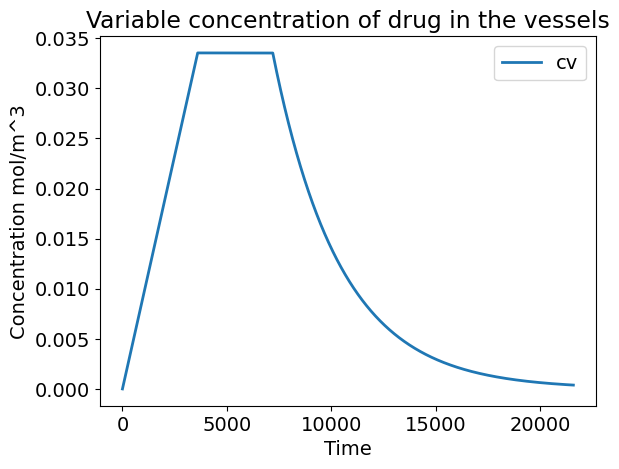

In [3]:
# Time of simulation
inizio = 0.0
fine = 21600.0 #6 ore
passo = 1 # 1s
num = int((fine - inizio) / passo) # numero di punti
time = np.linspace(inizio,fine,num) # asse temporale

# Exponential decay, elimination phase
def decay(t):
  c_v_decay = c_v0_tpz * np.exp(-t * (1/tau) )
  return c_v_decay

# Linear increase of the concentration
ca = (c_v0_tpz - 0)/3600 # cv0_tpz identified from literature

c_vv_rise = np.linspace(0, 3600, int(3600 / passo)) * ca
c_vv_const = np.ones(int(3600 / passo), dtype=float) * c_v0_tpz # constant phase
decay_time = np.linspace(0, fine - 7200, int((fine - 7200) / passo))  # exponential decay
c_vv_dec = decay(decay_time)

c_vv0 = np.concatenate([c_vv_rise, c_vv_const, c_vv_dec])
c_vv0.shape
plt.plot(time,c_vv0,label='cv') 
plt.xlabel('Time')
plt.ylabel('Concentration mol/m^3')
plt.title('Variable concentration of drug in the vessels')
plt.legend()

In [4]:
# Coupled problem for the drug and the oxygen, resolution through Runge Kutta method
import numpy as np
from scipy.integrate import trapz

K1_ox = 0.0
K2_ox = 0.0
K1_tpz = 0.0
K2_tpz = 0.0

def f_ox(c,SF):
    dcdt = -c * (K1_ox - K2_ox + K3_ox+ SF*(V_max_ox/(K_m_ox + c))) + (K2_ox * c_v0_ox + K3_ox * c_v0_ox)
    return dcdt
def f(c, suma, c_vv, ox):
    dcdt = -c * (K1_tpz - K2_tpz + K3_tpz) - (K / (K + ox)) * (k_met * c + (V_max_tpz * c) / (K_m_tpz + c)) * np.exp(-alpha * suma) * phi_0 + K2_tpz * c_vv + K3_tpz * c_vv
    return dcdt

# considerando 2h cresce linearmente per 50% del tempo, costante per 1h e decrescente esponenzialmente
c = [0.0]
c_vv = c_vv0
# num = int((fine - inizio) / passo)
SF = []
# time = np.linspace(inizio, fine, num)
aree = []
consumo_nl = [0.0]
m_app_cvvar = []
V_max_app_cvvar = []
flag = 0
consumo = []
consumosf = []
consumonoc = []
consumonocnosf = []

CM = [0.0]
c_ox = [0.0042344]
for i in time:

    suma = trapz(CM)
    c_temp = float(c[-1])
    k1 = f(c_temp, suma,c_vv[flag],c_ox[-1])
    k2 = f((c[-1] + (k1 / 2)*passo).astype(np.float64), suma, c_vv[flag],c_ox[-1])
    k3 = f((c[-1] + (k2 / 2)*passo).astype(np.float64), suma, c_vv[flag],c_ox[-1])
    k4 = f((c[-1] + k3*passo).astype(np.float64), suma, c_vv[flag],c_ox[-1])
    c_temp = c[-1] + (passo / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    SF_temp = np.exp(-alpha * suma)
    SF.append(SF_temp)
    c.append(c_temp)
    CM.append((K / (K + c_ox[-1])) * c_temp * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)))
    consumo.append((K / (K + c_ox[-1])) * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)))
    consumosf.append((K / (K + c_ox[-1])) * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)) * SF_temp)
    consumonoc.append((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)) * SF_temp)
    consumonocnosf.append((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)) * phi_0)
    area = ((float(CM[-1]) + float(CM[-2]))*float(passo))/2
    aree.append(suma)

    c_temp_ox = float(c_ox[-1])
    k1_ox = f_ox(c_temp_ox,float(SF_temp))
    k2_ox = f_ox((c_ox[-1] + (k1_ox / 2)*passo),float(SF_temp))
    k3_ox = f_ox((c_ox[-1] + (k2_ox / 2)*passo),float(SF_temp))
    k4_ox = f_ox((c_ox[-1] + k3_ox*passo),float(SF_temp))
    c_temp_ox = c_ox[-1] + (passo / 6) * (k1_ox + 2 * k2_ox + 2 * k3_ox + k4_ox)
    c_ox.append(c_temp_ox)
    flag = flag + 1



c_nlin_cvvar_ox = c
SF_nlin_cvvar_ox = SF

C:\Users\utente\AppData\Local\Temp\ipykernel_18420\1161448609.py:37: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  suma = trapz(CM)


Text(0.5, 1.0, 'Drug concentration in the tissue for the coupled problem')

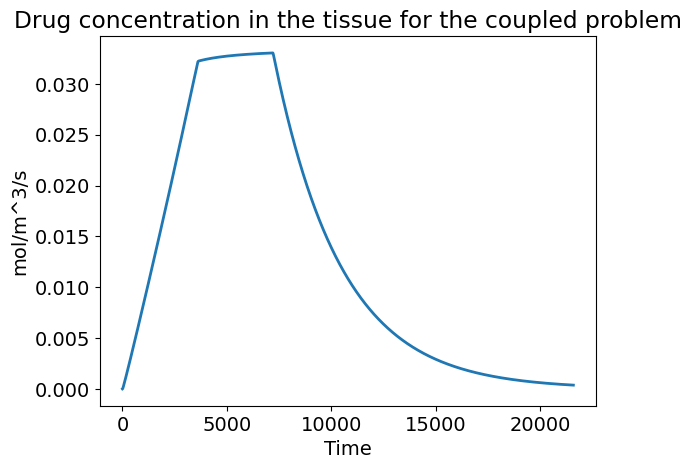

In [5]:
# Tissue concentration of the drug
plt.plot(time,c_nlin_cvvar_ox[0:-1])
plt.xlabel('Time')
plt.ylabel('mol/m^3/s')
plt.title('Drug concentration in the tissue for the coupled problem')

Text(0, 0.5, 'SF')

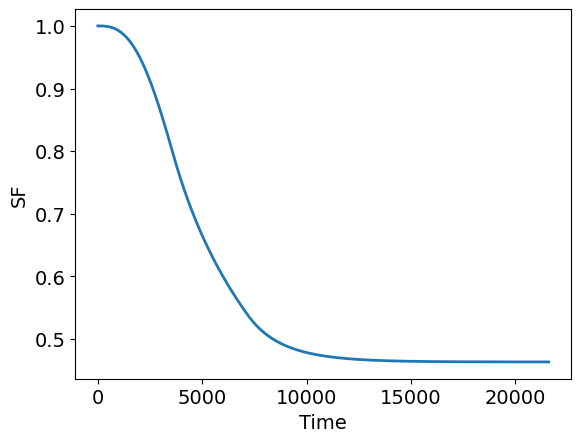

In [6]:
# SF
plt.plot(time,SF_nlin_cvvar_ox)
plt.xlabel('Time')
plt.ylabel('SF')

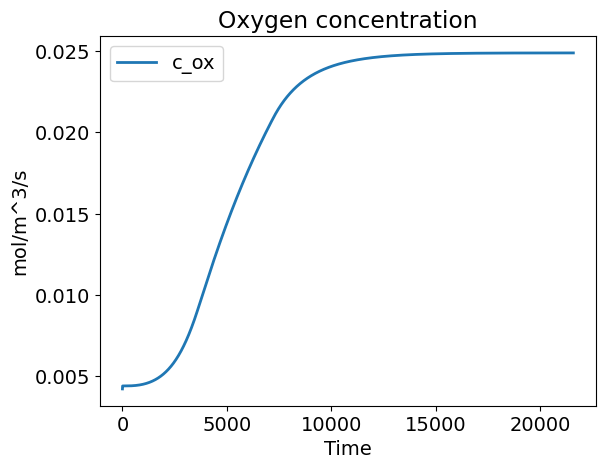

In [7]:
# Oxygen concentration in the tissue
plt.plot(time,c_ox[0:-1], label='c_ox')
plt.xlabel('Time')
plt.ylabel('mol/m^3/s')
plt.title('Oxygen concentration')
plt.legend()

1.0657924220204655
0.6012709149960392
0.0006466941222005291
4002.4812937446773


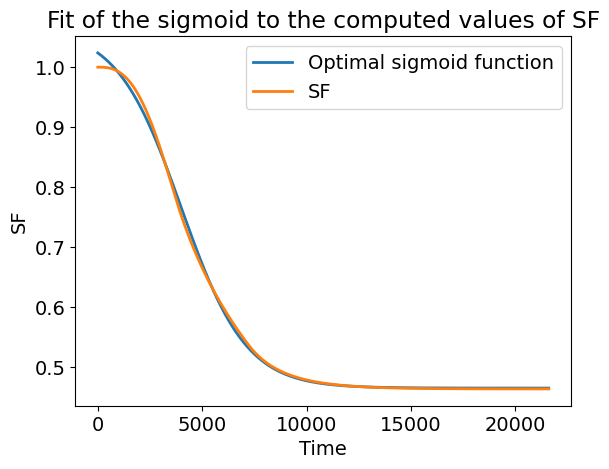

In [8]:
# Fitting the SF as a sigmoid
SF_nlin_cvvar_ox = np.array(SF_nlin_cvvar_ox)

m_app_cvvar = np.array(m_app_cvvar)
# SIgmoid function
def sigm(t,X,Y,Z,D):
  s = X - ((Y)/(1 + np.exp(-Z * (t - D))))
  return s

# Initialization of the parameters
X = max(SF_nlin_cvvar_ox)
Y = X - min(SF_nlin_cvvar_ox)
Z = 0.0005
D = len(time)/2

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt



params, covariance = curve_fit(sigm, time, SF_nlin_cvvar_ox, p0=[X, Y, Z, D])

XX, YY, ZZ, DD = params

sol = sigm(time,XX,YY,ZZ,DD)
plt.rc('font', size=14)
plt.rcParams['lines.linewidth'] = 2
plt.plot(time,sol,label='Optimal sigmoid function')
plt.plot(time,SF_nlin_cvvar_ox,label='SF')
plt.xlabel('Time')
plt.ylabel('SF')
plt.title('Fit of the sigmoid to the computed values of SF')
plt.legend()


# Sigmoid parameters
print(XX)
print(YY)
print(ZZ)
print(DD)

Text(0.5, 1.0, 'Rate of consumption r')

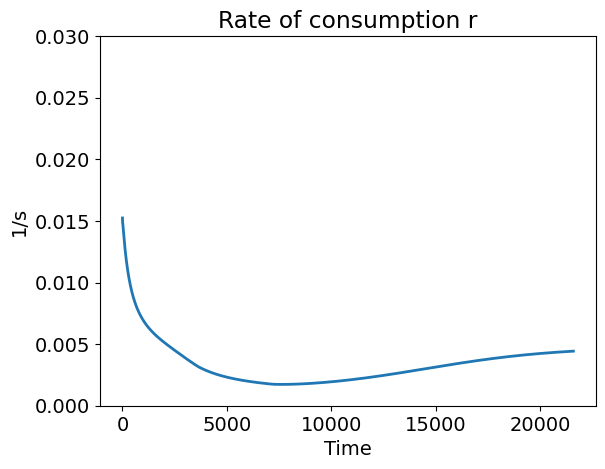

In [9]:
plt.plot(time,consumonocnosf) #parameter r modeled ((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)))
#plt.plot(time,iperbole(time,10,0,0.005))
plt.ylim(0,0.03)
plt.xlabel('Time')
plt.ylabel('1/s')
plt.title('Rate of consumption r')

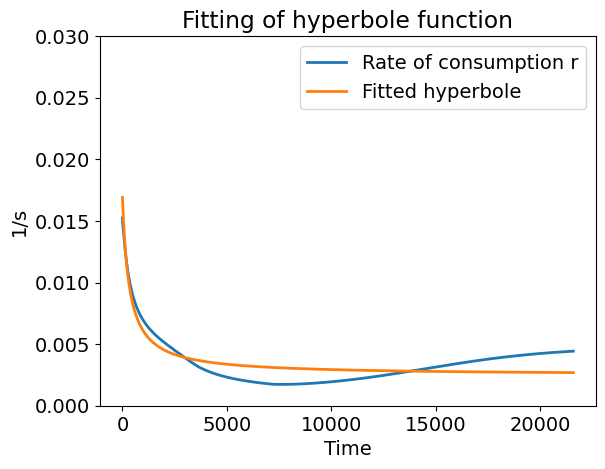

4.786454999003923
331.6163250967257
0.0024698791454990866


In [10]:
# Fit of r with an hyperbolic function
from scipy.optimize import curve_fit
def iperbole(x, a, b, cc):
    return a / (x + b) + cc

consumonocnosf = np.array(consumonocnosf) #(K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp))
consumonocnosf = consumonocnosf.flatten()
consumonocnosf.shape


params, covariance = curve_fit(iperbole, time, consumonocnosf)


a, b, cc = params


curve_fit_consumonocnosf = iperbole(time, a, b, cc)

# plot
plt.plot(time, consumonocnosf, label='Rate of consumption r')
plt.plot(time, curve_fit_consumonocnosf, label='Fitted hyperbole')
plt.legend()
plt.xlabel('Time')
plt.ylabel('1/s')
plt.title('Fitting of hyperbole function')
plt.ylim(0,0.03)
plt.show()

# Parmeterfs of the hyperbole
print(a)
print(b)
print(cc)